# Leaf Disease Detection

In [1]:
# import all dependencies
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import keras
import keras.utils
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.utils import load_img,img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, Dense, Concatenate, Dropout, MaxPooling2D, GlobalAveragePooling2D
from keras.applications.vgg19 import VGG19,preprocess_input,decode_predictions
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# set the paths for training, validation and test dataset
BASE_DIR = "/archive_2/PlantVillage"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "valid")
TEST_DIR = os.path.join(BASE_DIR, "test")
IMG_SHAPE  = (256, 256)
BATCH_SIZE = 32

In [3]:
# count of images in training dataset 
total_train = 0

for d in os.listdir(TRAIN_DIR):
    path = os.path.join(TRAIN_DIR, d)
    img_count = len(os.listdir(path))
    total_train += img_count
    print(f'{d:50} : {img_count}')

print(f'\nTotal training images: {total_train}')

Pepper_Bell_Bacterial_Spot                         : 997
Pepper_Bell_Healthy                                : 1478
Potato_Early_Blight                                : 1000
Potato_Healthy                                     : 152
Potato_Late_Blight                                 : 1000
Tomato_Bacterial_Spot                              : 2127
Tomato_Early_Blight                                : 1000
Tomato_Healthy                                     : 1591
Tomato_Late_Blight                                 : 1909
Tomato_Leaf_Mold                                   : 952
Tomato_Mosaic_Virus                                : 373
Tomato_Septoria_Leaf_Spot                          : 1771
Tomato_Spider_Mites_Two_Spotted_Spider_Mite        : 1676
Tomato_Target_Spot                                 : 1404
Tomato_YellowLeaf_Curl_Virus                       : 2127

Total training images: 19557


In [4]:
# count of images in validation dataset 
total_valid = 0

for d in os.listdir(VAL_DIR):
    path = os.path.join(VAL_DIR, d)
    img_count = len(os.listdir(path))
    total_valid += img_count
    print(f'{d:50} : {img_count}')

print(f'\nTotal testing images: {total_valid}')

Pepper_Bell_Bacterial_Spot                         : 200
Pepper_Bell_Healthy                                : 296
Potato_Early_Blight                                : 200
Potato_Healthy                                     : 31
Potato_Late_Blight                                 : 200
Tomato_Bacterial_Spot                              : 426
Tomato_Early_Blight                                : 200
Tomato_Healthy                                     : 319
Tomato_Late_Blight                                 : 382
Tomato_Leaf_Mold                                   : 191
Tomato_Mosaic_Virus                                : 75
Tomato_Septoria_Leaf_Spot                          : 355
Tomato_Spider_Mites_Two_Spotted_Spider_Mite        : 336
Tomato_Target_Spot                                 : 281
Tomato_YellowLeaf_Curl_Virus                       : 426

Total testing images: 3918


In [5]:
# count of images in testing dataset 
total_test = 0

for d in os.listdir(TEST_DIR):
    path = os.path.join(TEST_DIR, d)
    img_count = len(os.listdir(path))
    total_test += img_count
    print(f'{d:50} : {img_count}')

print(f'\nTotal testing images: {total_test}')

Pepper_Bell_Bacterial_Spot                         : 100
Pepper_Bell_Healthy                                : 148
Potato_Early_Blight                                : 100
Potato_Healthy                                     : 15
Potato_Late_Blight                                 : 100
Tomato_Bacterial_Spot                              : 213
Tomato_Early_Blight                                : 100
Tomato_Healthy                                     : 159
Tomato_Late_Blight                                 : 191
Tomato_Leaf_Mold                                   : 95
Tomato_Mosaic_Virus                                : 37
Tomato_Septoria_Leaf_Spot                          : 177
Tomato_Spider_Mites_Two_Spotted_Spider_Mites       : 168
Tomato_Target_Spot                                 : 140
Tomato_YellowLeaf_Curl_Virus                       : 213

Total testing images: 1956


In [6]:
# count of total class used for leaf disease detection
total_classes = len(os.listdir(TRAIN_DIR))

print(f'\nTotal number of classes: {total_classes}')


Total number of classes: 15


In [7]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("/archive_2/PlantVillage/train",
                                                           shuffle=True,
                                                           image_size=(256,256),
                                                           batch_size=32)

Found 19556 files belonging to 15 classes.


In [8]:
class_names=dataset.class_names
class_names

['Pepper_Bell_Bacterial_Spot',
 'Pepper_Bell_Healthy',
 'Potato_Early_Blight',
 'Potato_Healthy',
 'Potato_Late_Blight',
 'Tomato_Bacterial_Spot',
 'Tomato_Early_Blight',
 'Tomato_Healthy',
 'Tomato_Late_Blight',
 'Tomato_Leaf_Mold',
 'Tomato_Mosaic_Virus',
 'Tomato_Septoria_Leaf_Spot',
 'Tomato_Spider_Mites_Two_Spotted_Spider_Mite',
 'Tomato_Target_Spot',
 'Tomato_YellowLeaf_Curl_Virus']

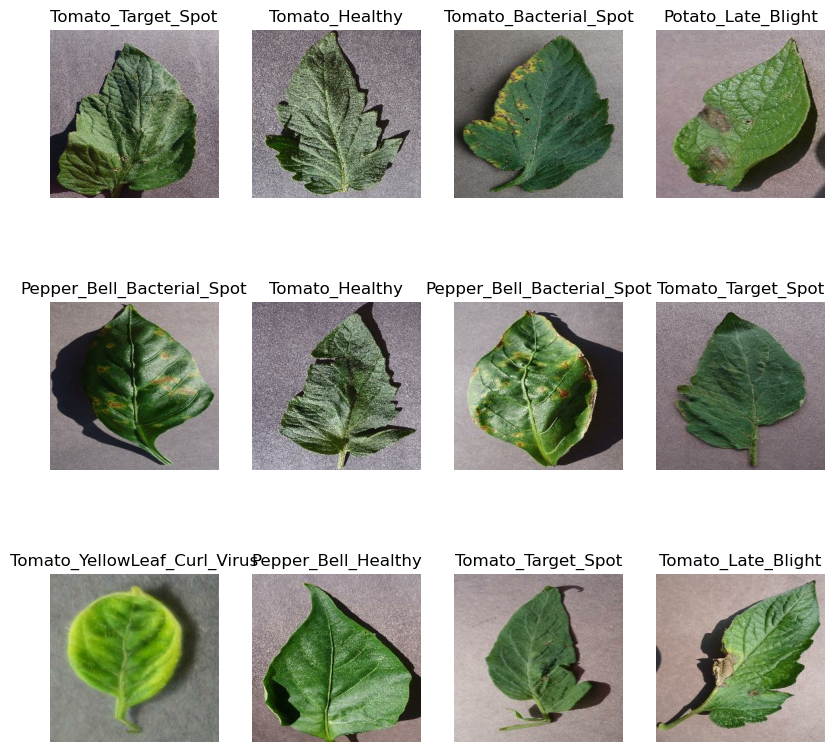

In [9]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

# Loading training, validation and testing dataset

In [9]:
# create training data generator with data augmentation
train_image_gen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 15,
        width_shift_range = 0.05,
        height_shift_range = 0.05,
        shear_range = 0.05,
        zoom_range = 0.05,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode = 'reflect'
    )

train_data_gen = train_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = TRAIN_DIR,
        shuffle = True,
        target_size = IMG_SHAPE
    )

Found 19556 images belonging to 15 classes.


In [10]:
# create validation data generator
# No need of data augmentation for validation dataset, it may mislead the result
val_image_gen = ImageDataGenerator(rescale = 1./255)

val_data_gen = val_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = VAL_DIR,
        shuffle = True,
        target_size = IMG_SHAPE
    )

Found 3918 images belonging to 15 classes.


In [11]:
# create testing data generator
# No need of data augmentation for testing dataset, it may mislead the result
test_image_gen = ImageDataGenerator(rescale = 1./255)

test_data_gen = test_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = TEST_DIR,
        shuffle = True,
        target_size = IMG_SHAPE
    )

Found 1956 images belonging to 15 classes.


In [12]:
class_name_lookup = {name: index for index, name in train_data_gen.class_indices.items()}

for k, v in class_name_lookup.items():
    print(f"{k:2} : {v}")

 0 : Pepper_Bell_Bacterial_Spot
 1 : Pepper_Bell_Healthy
 2 : Potato_Early_Blight
 3 : Potato_Healthy
 4 : Potato_Late_Blight
 5 : Tomato_Bacterial_Spot
 6 : Tomato_Early_Blight
 7 : Tomato_Healthy
 8 : Tomato_Late_Blight
 9 : Tomato_Leaf_Mold
10 : Tomato_Mosaic_Virus
11 : Tomato_Septoria_Leaf_Spot
12 : Tomato_Spider_Mites_Two_Spotted_Spider_Mite
13 : Tomato_Target_Spot
14 : Tomato_YellowLeaf_Curl_Virus


# Model

# Input Layer

In [13]:
inputs = tf.keras.Input(shape = (*IMG_SHAPE, 3), name = "Input")
inputs.shape

TensorShape([None, 256, 256, 3])

# Depthwise Convolution + Pointwise Convolution + Max Pooling blocks

# Block 1

In [14]:
depth_conv_1 = DepthwiseConv2D(2, depth_multiplier = 8, padding = "same", activation = "relu", name = "DwC_1")(inputs)
depth_conv_1.shape

TensorShape([None, 256, 256, 24])

In [15]:
point_conv_1 = Conv2D(32, 1, activation = "relu", name = "PwC_1")(depth_conv_1)
point_conv_1.shape

TensorShape([None, 256, 256, 32])

In [16]:
max_pool_1 = MaxPooling2D(name = "MP_1")(point_conv_1)
max_pool_1.shape

TensorShape([None, 128, 128, 32])

# Block 2

In [17]:
depth_conv_2 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_2")(max_pool_1)
depth_conv_2.shape

TensorShape([None, 128, 128, 32])

In [18]:
point_conv_2 = Conv2D(32 * 2, 1, activation = "relu", name = "PwC_2")(depth_conv_2)
point_conv_2.shape

TensorShape([None, 128, 128, 64])

In [19]:
max_pool_2 = MaxPooling2D(name = "MP_2")(point_conv_2)
max_pool_2.shape

TensorShape([None, 64, 64, 64])

# Block 3

In [20]:
depth_conv_3 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_3")(max_pool_2)
depth_conv_3.shape

TensorShape([None, 64, 64, 64])

In [21]:
point_conv_3 = Conv2D(32 * 4, 1, activation = "relu", name = "PwC_3")(depth_conv_3)
point_conv_3.shape

TensorShape([None, 64, 64, 128])

In [22]:
max_pool_3 = MaxPooling2D(name = "MP_3")(point_conv_3)
max_pool_3.shape

TensorShape([None, 32, 32, 128])

# Block 4

In [23]:
depth_conv_4 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_4")(max_pool_3)
depth_conv_4.shape

TensorShape([None, 32, 32, 128])

In [24]:
point_conv_4 = Conv2D(32 * 8, 1, activation = "relu", name = "PwC_4")(depth_conv_4)
point_conv_4.shape

TensorShape([None, 32, 32, 256])

In [25]:
max_pool_4 = MaxPooling2D(name = "MP_4")(point_conv_4)
max_pool_4.shape

TensorShape([None, 16, 16, 256])

# Block 5

In [26]:
depth_conv_5 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_5")(max_pool_4)
depth_conv_5.shape

TensorShape([None, 16, 16, 256])

In [27]:
point_conv_5 = Conv2D(32 * 16, 1, activation = "relu", name = "PwC_5")(depth_conv_5)
point_conv_5.shape

TensorShape([None, 16, 16, 512])

In [28]:
max_pool_5 = MaxPooling2D(name = "MP_5")(point_conv_5)
max_pool_5.shape

TensorShape([None, 8, 8, 512])

# Global Average Pooling layers for each block

In [29]:
global_avg_1 = GlobalAveragePooling2D(name = "GAP_1")(max_pool_1)
global_avg_1.shape

TensorShape([None, 32])

In [30]:
global_avg_2 = GlobalAveragePooling2D(name = "GAP_2")(max_pool_2)
global_avg_2.shape

TensorShape([None, 64])

In [31]:
global_avg_3 = GlobalAveragePooling2D(name = "GAP_3")(max_pool_3)
global_avg_3.shape

TensorShape([None, 128])

In [32]:
global_avg_4 = GlobalAveragePooling2D(name = "GAP_4")(max_pool_4)
global_avg_4.shape

TensorShape([None, 256])

In [33]:
global_avg_5 = GlobalAveragePooling2D(name = "GAP_5")(max_pool_5)
global_avg_5.shape

TensorShape([None, 512])

# Concatenation Layer

In [34]:
concatenated = Concatenate(name = "Concat")([global_avg_1, global_avg_2, global_avg_3, global_avg_4, global_avg_5])
concatenated.shape

TensorShape([None, 992])

# Dropout and Dense Layers

In [35]:
DROPOUT_PERCENTS = [0.2, 0.2]

In [36]:
dropout_1 = Dropout(DROPOUT_PERCENTS[0], name = "Droput_1")(concatenated)
dropout_1.shape

TensorShape([None, 992])

In [37]:
dense_1 = Dense(512, activation = "relu", name = "Dense_1")(dropout_1)
dense_1.shape

TensorShape([None, 512])

In [38]:
dropout_2 = Dropout(DROPOUT_PERCENTS[1], name = "Dropout_2")(dense_1)
dropout_2.shape

TensorShape([None, 512])

In [39]:
dense_2 = Dense(total_classes, activation = "softmax", name = "Output")(dropout_2)
dense_2.shape

TensorShape([None, 15])

# Model Summary

In [40]:
model = Model(inputs = inputs, outputs = dense_2, name = "Leaf_Disease")
model.summary()

Model: "Leaf_Disease"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 DwC_1 (DepthwiseConv2D)        (None, 256, 256, 24  120         ['Input[0][0]']                  
                                )                                                                 
                                                                                                  
 PwC_1 (Conv2D)                 (None, 256, 256, 32  800         ['DwC_1[0][0]']                  
                                )                                                      

In [41]:
# Compile the model
model.compile(optimizer='adam',
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [42]:
TB_LOGS = "tensorboard_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [43]:
# Callbacks
from keras.callbacks import ModelCheckpoint,EarlyStopping
earlyStop = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)
tensorBoard = TensorBoard(log_dir = TB_LOGS, histogram_freq = 1)
#model check point
mc=ModelCheckpoint(filepath="best_model.h5",
                    monitor = 'val_accuracy',
                    patience= 5,
                    verbose=1,
                    save_best_only=True)
 
cb = [earlyStop,tensorBoard,mc]

# Training the model

In [45]:
%%time
hi = model.fit(
    train_data_gen,
    verbose=1,
    callbacks=cb,
    validation_data=val_data_gen,
    epochs=30,
    max_queue_size =25
)

Epoch 1/30
612/612 [==============================] - ETA: 0s - loss: 2.2735 - accuracy: 0.2385
Epoch 1: val_accuracy improved from -inf to 0.38923, saving model to best_model.h5
612/612 [==============================] - 1370s 2s/step - loss: 2.2735 - accuracy: 0.2385 - val_loss: 1.8695 - val_accuracy: 0.3892
Epoch 2/30
612/612 [==============================] - ETA: 0s - loss: 1.5455 - accuracy: 0.4886
Epoch 2: val_accuracy improved from 0.38923 to 0.53012, saving model to best_model.h5
612/612 [==============================] - 1263s 2s/step - loss: 1.5455 - accuracy: 0.4886 - val_loss: 1.3583 - val_accuracy: 0.5301
Epoch 3/30
612/612 [==============================] - ETA: 0s - loss: 1.1346 - accuracy: 0.6206
Epoch 3: val_accuracy improved from 0.53012 to 0.63017, saving model to best_model.h5
612/612 [==============================] - 1256s 2s/step - loss: 1.1346 - accuracy: 0.6206 - val_loss: 1.0544 - val_accuracy: 0.6302
Epoch 4/30
612/612 [==============================] - ETA:

In [102]:
# load best model
from keras.models import load_model
model=load_model("/archive_2/PlantVillage/best_model.h5")

In [46]:
# evaluate the model on the test dataset
# Print the test accuracy
score=model.evaluate(test_data_gen)[1]
print(f"the accuracy of your model is={score*100}%")

62/62 [==============================] - 58s 931ms/step - loss: 0.1288 - accuracy: 0.9581
the accuracy of your model is=95.80777287483215%


In [48]:
hi.params

{'verbose': 1, 'epochs': 30, 'steps': 612}

In [49]:
h= hi.history
h.keys()
print(h)

{'loss': [2.2735140323638916, 1.545508861541748, 1.1346338987350464, 0.8894824385643005, 0.6844460964202881, 0.5388926267623901, 0.4418673515319824, 0.37872055172920227, 0.3186682462692261, 0.2946174740791321, 0.2521286904811859, 0.24694588780403137, 0.2139347493648529, 0.2065419852733612, 0.18979308009147644, 0.18482708930969238, 0.17607562243938446, 0.1680881530046463, 0.16534669697284698, 0.14517611265182495, 0.14481855928897858, 0.13636258244514465], 'accuracy': [0.23849457502365112, 0.4885968565940857, 0.6206279397010803, 0.6972796320915222, 0.7658519148826599, 0.8181120753288269, 0.8532931208610535, 0.8726733326911926, 0.8906217813491821, 0.9021783471107483, 0.9155246615409851, 0.916496217250824, 0.9265187382698059, 0.9297913908958435, 0.9355696439743042, 0.9373593926429749, 0.9411433935165405, 0.9417570233345032, 0.9424728751182556, 0.9502454400062561, 0.9498363733291626, 0.9539783000946045], 'val_loss': [1.8695051670074463, 1.3583059310913086, 1.0543705224990845, 0.920562982559

In [50]:
len(hi.history['loss'])

22

In [51]:
# show loss for first 5 epochs
hi.history['loss'][:5]

[2.2735140323638916,
 1.545508861541748,
 1.1346338987350464,
 0.8894824385643005,
 0.6844460964202881]

In [52]:
acc=hi.history['accuracy']
val_acc=hi.history['val_accuracy']
loss=hi.history['loss']
val_loss=hi.history['val_loss']

In [53]:
PLOTS_DPI = 200

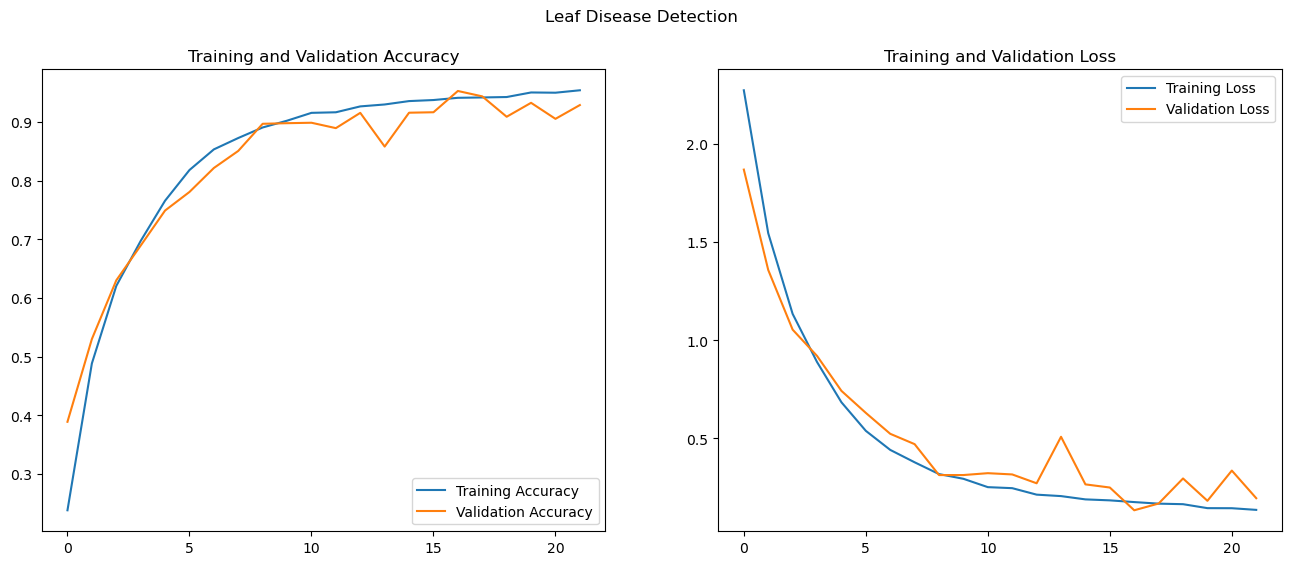

In [54]:
acc = hi.history['accuracy']
val_acc = hi.history['val_accuracy']

loss = hi.history['loss']
val_loss = hi.history['val_loss']

epochs_range = hi.epoch

plt.figure(figsize = (16, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.suptitle('Leaf Disease Detection')

plt.savefig('plots_1/acc_and_loss.jpg', dpi = PLOTS_DPI, bbox_inches='tight')
plt.show()

In [47]:
data=tf.keras.preprocessing.image_dataset_from_directory("/archive_2/PlantVillage/test",
                                                           shuffle=True,
                                                           image_size=(256,256),
                                                           batch_size=32)

Found 1956 files belonging to 15 classes.


14
Image to predict
actual label: Tomato_YellowLeaf_Curl_Virus
1/1 [==============================] - 1s 1s/step
predicted label: Pepper_Bell_Healthy


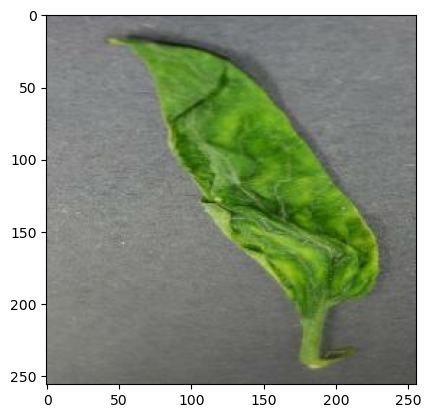

In [48]:
# Run prediction on a sample image
for images_batch,labels_batch in data.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    print(first_label)
    print("Image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    batch_prediction=model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [8]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 73ms/step


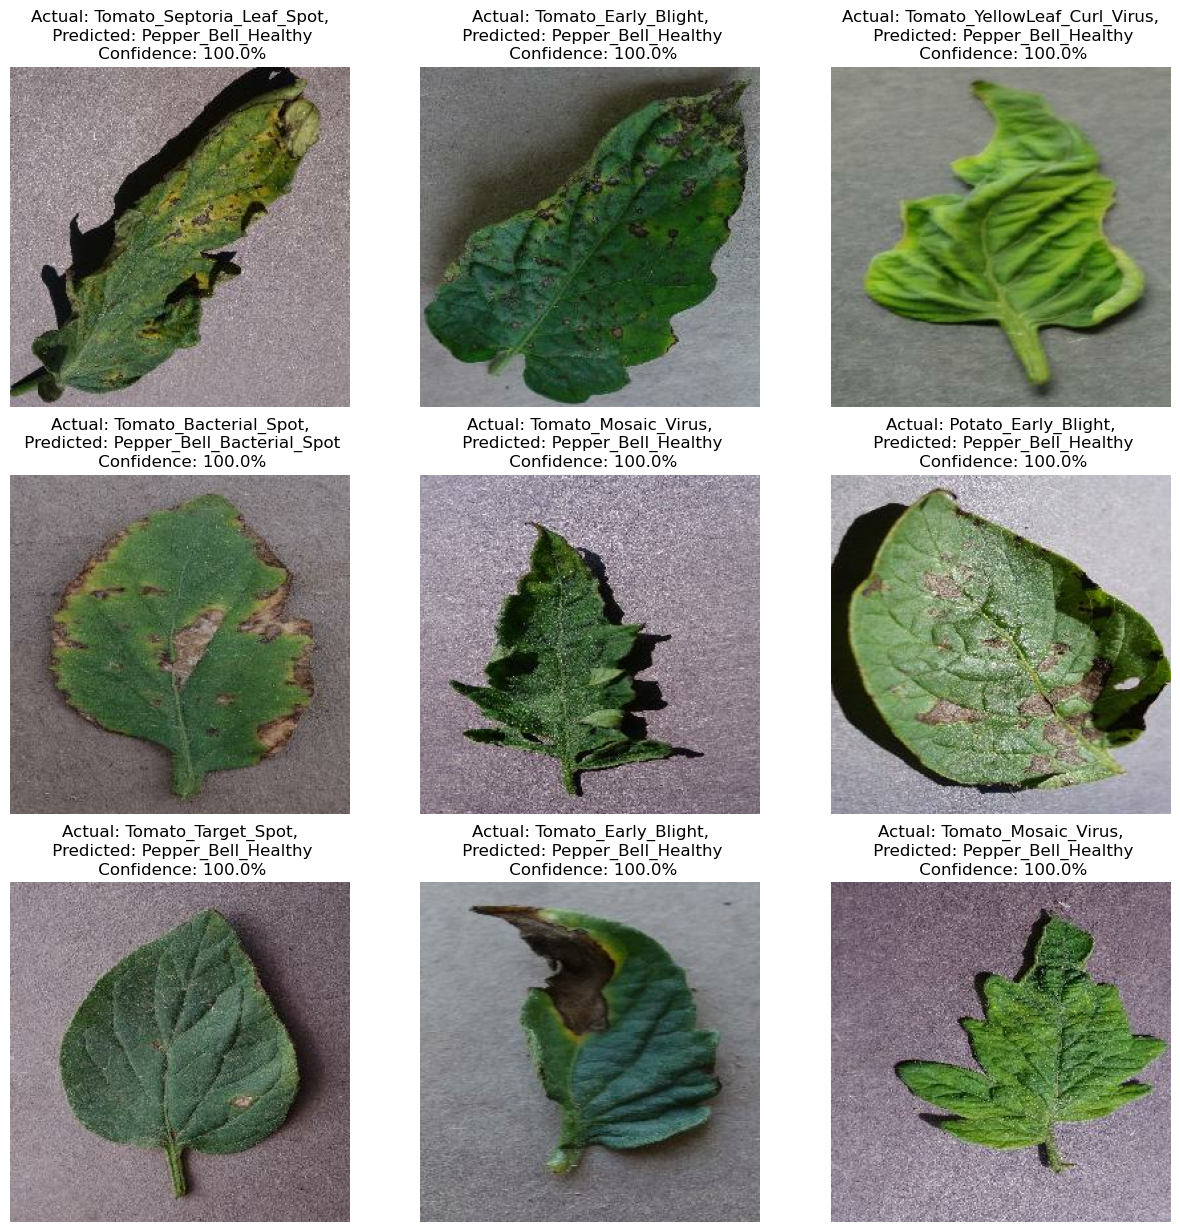

In [9]:
plt.figure(figsize=(15,15))
for images,labels in data.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}\n Confidence: {confidence}%")
        plt.axis("off")

In [98]:
ref=dict(zip(list(train_data_gen.class_indices.values()),list(train_data_gen.class_indices.keys())))

In [99]:
# Pre-Processing test data same as train data.
def prediction(path):
    img = load_img(path,target_size=(256,256))
    i = img_to_array(img)
    im=preprocess_input(i)
    img=np.expand_dims(im,axis=0)
    pred=np.argmax(model.predict(img))
    print(f"the image belongs to {ref[pred]}")

1/1 [==============================] - 0s 334ms/step
the image belongs to Pepper_Bell_Healthy


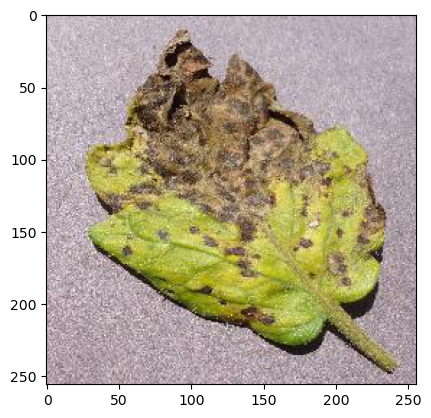

In [103]:
path="/archive_2/PlantVillage/test/Tomato_Septoria_Leaf_Spot/c4.JPG"
prediction(path)
leaf=tf.keras.utils.load_img(path)
plt.imshow(leaf)

In [62]:
from sklearn.metrics import classification_report
# Get the predicted classes for the test set
y_pred=np.argmax(model.predict(test_data_gen),axis=1)
# Get the true classes for the test set
y_true=test_data_gen.classes
print(classification_report(y_true,y_pred))
print(confusion_matrix(y_true,y_pred))

62/62 [==============================] - 39s 621ms/step
              precision    recall  f1-score   support

           0       0.04      0.04      0.04       100
           1       0.04      0.05      0.05       148
           2       0.07      0.07      0.07       100
           3       0.00      0.00      0.00        15
           4       0.06      0.05      0.05       100
           5       0.12      0.11      0.12       213
           6       0.06      0.06      0.06       100
           7       0.09      0.09      0.09       159
           8       0.13      0.14      0.14       191
           9       0.07      0.07      0.07        95
          10       0.00      0.00      0.00        37
          11       0.08      0.08      0.08       177
          12       0.10      0.10      0.10       168
          13       0.07      0.06      0.07       140
          14       0.09      0.10      0.10       213

    accuracy                           0.08      1956
   macro avg       0.07 

In [63]:
evaluation_data_gen = test_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = TEST_DIR,
        shuffle = False,
        target_size = IMG_SHAPE
    )

Found 1956 images belonging to 15 classes.


In [ ]:
val_true = evaluation_data_gen.classes
val_pred = np.argmax(model.predict(evaluation_data_gen), axis = 1)

_, ax = plt.subplots(figsize = (20, 16))

ConfusionMatrixDisplay(confusion_matrix(val_true, val_pred, labels = list(class_name_lookup.keys())),
                        display_labels = list(class_name_lookup.values())
                        ).plot(ax = ax, xticks_rotation = 'vertical')
                        
plt.savefig('plots_1/confusion_matrix.jpg', dpi = PLOTS_DPI, bbox_inches = 'tight')
plt.show()

62/62 [==============================] - 38s 617ms/step


In [58]:
model.save('models/plant_leaf_disease_detector')

INFO:tensorflow:Assets written to: models/plant_leaf_disease_detector\assets


INFO:tensorflow:Assets written to: models/plant_leaf_disease_detector\assets
